# Solution to the hardware native 27 qubit Maxcut Problem

In this notebook we show how to transpile the hardware native 27 qubit maxcut problem. The transpiled circuit can then be executed in a QAOA framework. The graph of the problem is shown below.

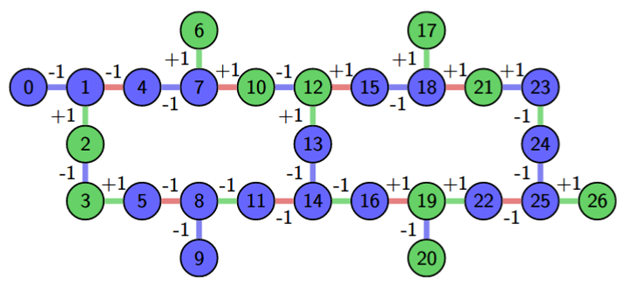

In [1]:
import json
import numpy as np
import qiskit.quantum_info as qi
import matplotlib.pyplot as plt

from qiskit import transpile
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import QAOAAnsatz
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.providers.fake_provider import FakeMumbai
from qiskit.transpiler import CouplingMap, PassManager
from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import (
    SwapStrategy,
    FindCommutingPauliEvolutions,
    Commuting2qGateRouter,
)

from qiskit_optimization import QuadraticProgram

In [2]:
data = json.load(open("../../problem_paulis.json"))
op = qi.SparsePauliOp.from_list(data["paulis"])

In [3]:
qp = QuadraticProgram()
qp.read_from_lp_file("../../problem_lp.txt")
print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Max-cut

Maximize
 obj: - x_0 - x_1 - 2 x_4 + x_6 + x_7 - 3 x_8 - x_9 - 2 x_11 + x_12 - 3 x_14
      + x_17 + x_18 + x_19 - x_20 + 2 x_21 - 2 x_24 - x_25 + x_26 + [ 4 x_0*x_1
      + 4 x_1*x_4 - 4 x_1*x_2 + 4 x_4*x_7 - 4 x_6*x_7 - 4 x_7*x_10 + 4 x_8*x_9
      + 4 x_8*x_11 + 4 x_8*x_5 + 4 x_11*x_14 + 4 x_12*x_10 - 4 x_12*x_13
      - 4 x_12*x_15 + 4 x_14*x_13 + 4 x_14*x_16 - 4 x_17*x_18 - 4 x_18*x_21
      + 4 x_18*x_15 + 4 x_19*x_20 - 4 x_19*x_16 - 4 x_19*x_22 - 4 x_21*x_23
      + 4 x_24*x_25 + 4 x_24*x_23 - 4 x_25*x_26 + 4 x_25*x_22 + 4 x_2*x_3
      - 4 x_3*x_5 ]/2
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_4 <= 1
 0 <= x_6 <= 1
 0 <= x_7 <= 1
 0 <= x_8 <= 1
 0 <= x_9 <= 1
 0 <= x_11 <= 1
 0 <= x_12 <= 1
 0 <= x_14 <= 1
 0 <= x_17 <= 1
 0 <= x_18 <= 1
 0 <= x_19 <= 1
 0 <= x_20 <= 1
 0 <= x_21 <= 1
 0 <= x_24 <= 1
 0 <= x_25 <= 1
 0 <= x_26 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_5 <= 1
 

Load backend information and transpile the quantum circuit.

In [4]:
backend = FakeMumbai()

In [5]:
circ = QuantumCircuit(27)
circ.append(PauliEvolutionGate(op, Parameter("γ")), range(27))

In [6]:
swap_strat = SwapStrategy(CouplingMap(backend.configuration().coupling_map), ())
pass_manager = PassManager([FindCommutingPauliEvolutions(), Commuting2qGateRouter(swap_strat)])

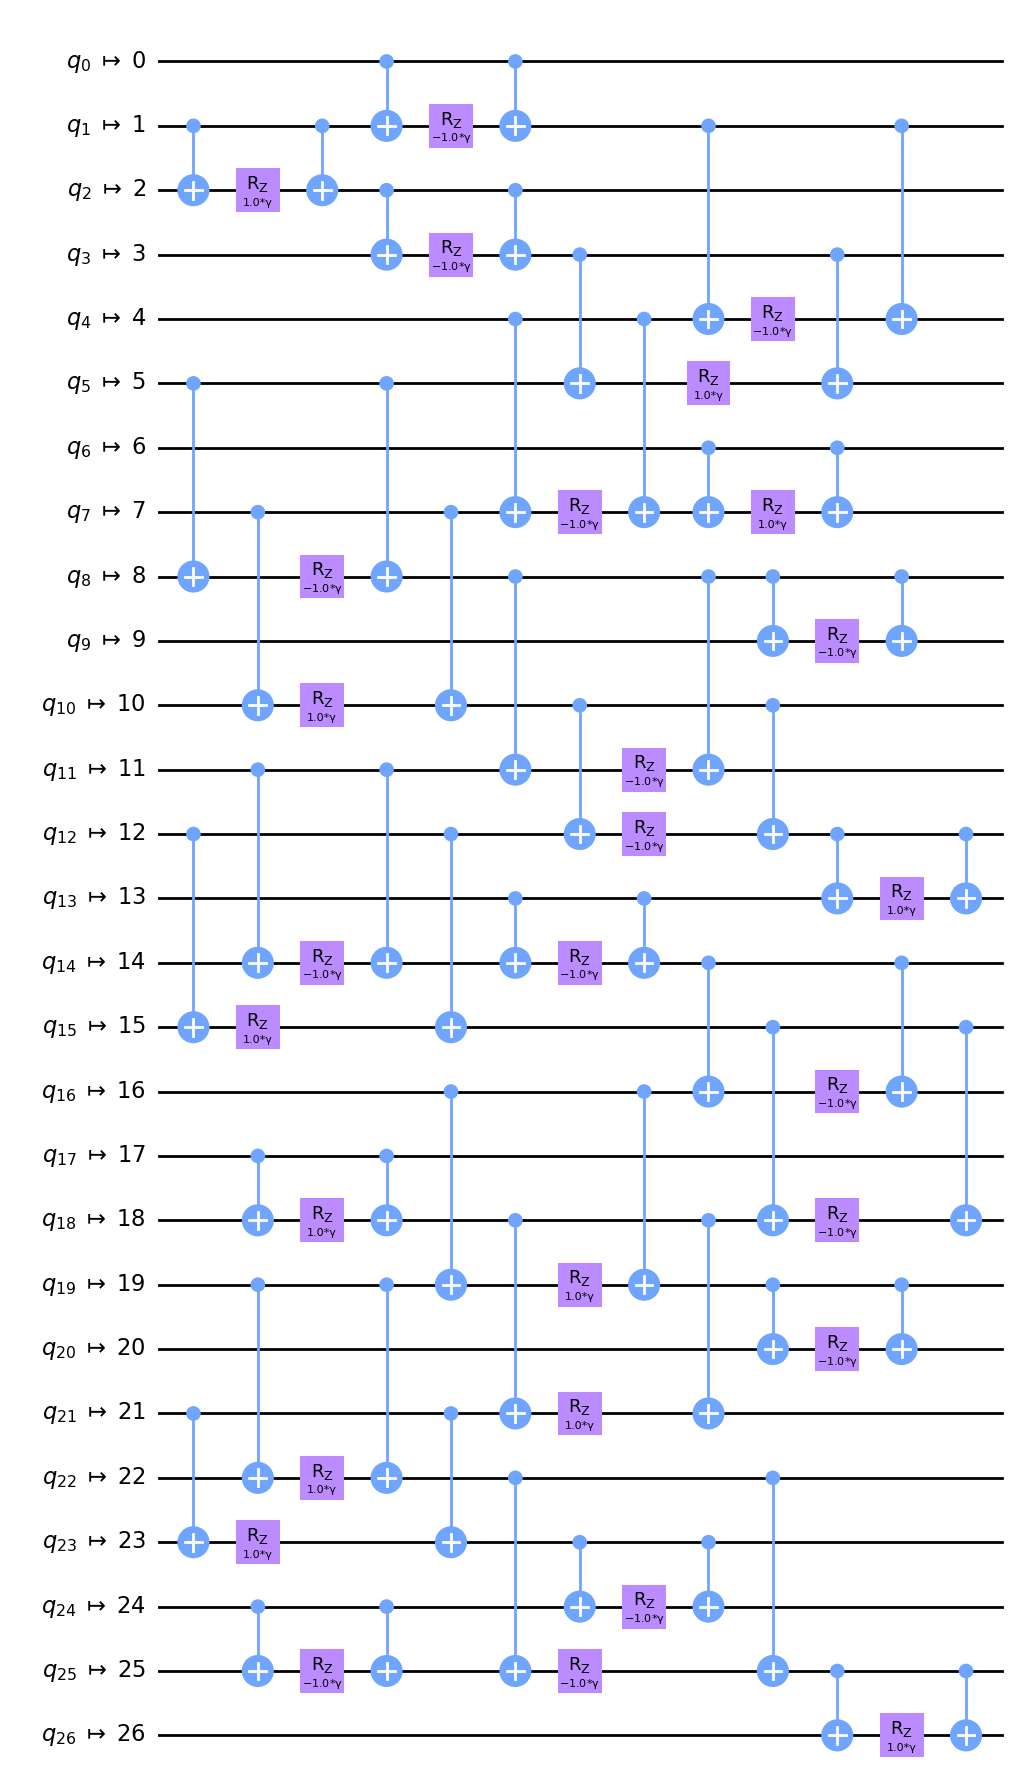

In [7]:
transpile(pass_manager.run(circ), backend).draw("mpl")

## Known hardware result

The problem shown above was executed on *ibmq_mumbai*, a cross-resonance based IBM Quantum system. With [CVaR aggregation](https://quantum-journal.org/papers/q-2020-04-20-256/) and [pulse-efficient transpilation](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.3.043088) the system was able to find the maximum cut with a depth one and depth two QAOA. The detaisl are published in [Scaling of the quantum approximate optimization algorithm on superconducting qubit based hardware](https://quantum-journal.org/papers/q-2022-12-07-870/).

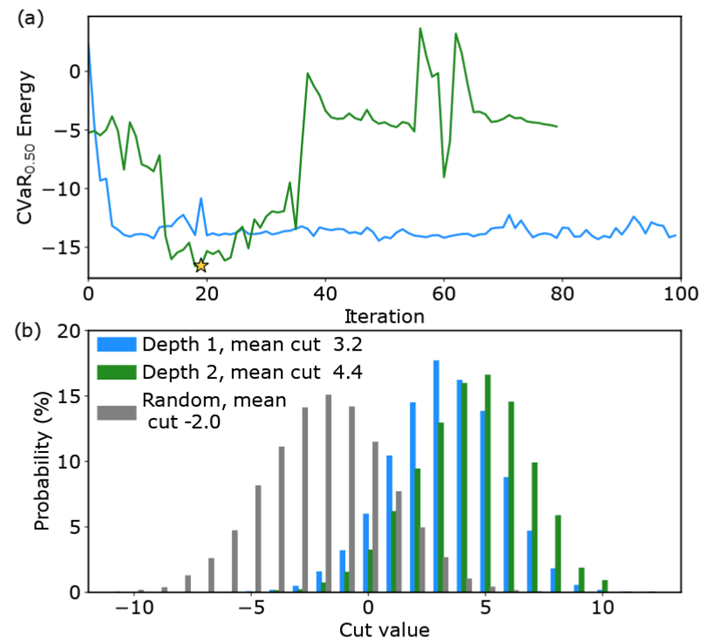

Below, we load the data of the depth-two QAOA from the paper and plot it. Keep in mind, that the paper is showing the average of two function evaluations as one iteration of SPSA. Below, we simply plot the energy as a function of the number of times we evaluate the Hamiltonian.

In [8]:
data = np.genfromtxt('solution_1.csv', delimiter=',', names=True)

Text(0, 0.5, 'CVaR Energy')

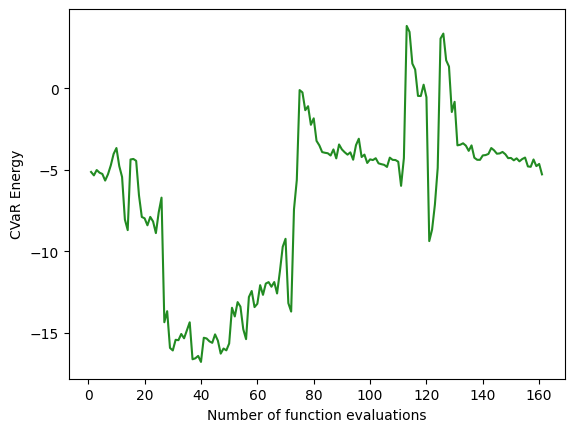

In [9]:
plt.plot(data["nfevs"], data["energy"], color="forestgreen")
plt.xlabel("Number of function evaluations")
plt.ylabel("CVaR Energy")

## References

[1] Panagiotis Kl. Barkoutsos, Giacomo Nannicini, Anton Robert, Ivano Tavernelli, and Stefan Woerner, "*Improving Variational Quantum Optimization using CVaR*", Quantum **4**, 256 (2020).

[2] Nathan Earnest, Caroline Tornow, and Daniel J. Egger, "*Pulse-efficient circuit transpilation for quantum applications on cross-resonance-based hardware*", Physics Review Research **3**, 043088 (2021).


[3] Johannes Weidenfeller, Lucia C. Valor, Julien Gacon, Caroline Tornow, Luciano Bello, Stefan Woerner, and Daniel J. Egger, "*Scaling of the quantum approximate optimization algorithm on superconducting qubit based hardware*", Quantum **6**, 870 (2022).